In [1]:
from importlib import reload
#reload(Utilities)

import sys, os
import re

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from scipy import stats
import datetime
import time

import pyodbc
#---------------------------------------------------------------------
sys.path.insert(0, os.path.realpath('..'))
import Utilities_config
#-----
import CommonLearningMethods as clm
#---------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_utilities_dir())
import Utilities
import Utilities_df
import Utilities_dt
import Plot_General
import Plot_Box_sns
import GrubbsTest

Here is the mini-drill too:
1.	Pull the voltage interval data from the last week (10/3 – 10/10) for all meters connected to the transformer numbers 1842743703178 and 1848771706723. You’ll have to join the meter_premise and the reading_ivl_nonvee tables in Hadoop
2.	Plot the voltage data over the week for these meters. Let’s do two different graphs; one for each transformer and their respective meters

Small note: to view the voltage out of the interval data, you’ll have to put aep_derived_uom = 'VOLT' in your WHERE statement


# NOTES

usage_date in usage_nonvee.reading_ivl_nonvee can be used for date instead of grabbing from e.g. starttimeperiod
<br> Try to complete data prep and cleaning in SQL instead of Python

In [2]:
cols_of_interest_met_prem = [
    'mfr_devc_ser_nbr',
    'mtr_stat_cd_desc',
    'first_in_srvc_dt',
    'phys_inst_dt',
    'inst_tod_cd',
    'inst_ts',
    'last_fld_test_date',
    'longitude',
    'latitude',
    'state_cd', 
    'prem_nb',
    'prem_stat_cd',
    'frst_turn_on_dt',
    'hsng_ctgy_cd',
    'srvc_pole_nb',
    'trsf_pole_nb',
    'curr_bill_acct_id',
    'curr_bill_acct_nb',
    'annual_kwh',
    'annual_max_dmnd',
    'latitude_nb',
    'longitude_nb',
    'station_nb', 
    'xfmr_nb'
]

cols_of_interest_usage = [
    'serialnumber', 
    'starttimeperiod', 
    'endtimeperiod', 
    'aep_endtime_utc', 
    'timezoneoffset', 
    'aep_srvc_qlty_idntfr', 
    'value', 
    'aep_opco', 
    'aep_usage_dt']

In [3]:
# Join by 'mfr_devc_ser_nbr' in default.meter_premise
#         'serialnumber' in usage_nonvee.reading_ivl_nonvee

In [4]:
conn = Utilities.get_athena_prod_aws_connection()

In [5]:
compare_sql_queries = False

In [6]:
sql_1 = (
"""
WITH MP
AS (
    SELECT {}
    FROM default.meter_premise
    WHERE trsf_pole_nb IN ('1842743703178', '1848771706723')
),
U AS (
    SELECT {}
    FROM usage_nonvee.reading_ivl_nonvee
    WHERE aep_usage_dt BETWEEN '2021-10-03' AND '2021-10-10'
    AND aep_derived_uom = 'VOLT'
)

SELECT {}
FROM MP
INNER JOIN U
ON MP.mfr_devc_ser_nbr = U.serialnumber
"""
).format(','.join(cols_of_interest_met_prem), 
         ','.join(cols_of_interest_usage), 
         ','.join([f'MP.{x} AS {x}' for x in cols_of_interest_met_prem] + [f'U.{x} AS {x}' for x in cols_of_interest_usage]))

In [7]:
sql_2 = (
"""
WITH MP
AS (
	SELECT {}
	FROM default.meter_premise
	WHERE trsf_pole_nb IN ('1842743703178', '1848771706723')
),
U AS (
	SELECT {}
	FROM usage_nonvee.reading_ivl_nonvee
	WHERE aep_usage_dt BETWEEN '2021-10-03' AND '2021-10-10'
	AND aep_derived_uom = 'VOLT'
	AND aep_opco IN (SELECT DISTINCT(LOWER(MP.state_cd)) FROM MP)
)

SELECT {}
FROM MP
INNER JOIN U
ON MP.mfr_devc_ser_nbr = U.serialnumber
"""
).format(','.join(cols_of_interest_met_prem), 
         ','.join(cols_of_interest_usage), 
         ','.join([f'MP.{x} AS {x}' for x in cols_of_interest_met_prem] + [f'U.{x} AS {x}' for x in cols_of_interest_usage]))

In [8]:
sql_3 = (
"""
WITH MP
AS (
	SELECT {}
	FROM default.meter_premise
	WHERE trsf_pole_nb IN ('1842743703178', '1848771706723')
),
U AS (
	SELECT {}
	FROM usage_nonvee.reading_ivl_nonvee
	WHERE aep_usage_dt BETWEEN '2021-10-03' AND '2021-10-10'
	AND aep_derived_uom = 'VOLT'
)

SELECT {}
FROM MP
INNER JOIN U
ON MP.mfr_devc_ser_nbr = U.serialnumber
AND LOWER(MP.state_cd) = U.aep_opco
"""
).format(','.join(cols_of_interest_met_prem), 
         ','.join(cols_of_interest_usage), 
         ','.join([f'MP.{x} AS {x}' for x in cols_of_interest_met_prem] + [f'U.{x} AS {x}' for x in cols_of_interest_usage]))

In [9]:
start = time.time()
df_2 = pd.read_sql(sql_2, conn)
time_2 = time.time() - start
df_2['starttimeperiod'] = df_2['starttimeperiod'].apply(lambda x: Utilities_dt.clean_timeperiod_entry(x))
df_2['endtimeperiod'] = df_2['endtimeperiod'].apply(lambda x: Utilities_dt.clean_timeperiod_entry(x))
df_2 = df_2.sort_values(by=['mfr_devc_ser_nbr', 'starttimeperiod'], ignore_index=True)
df_usage = df_2.copy()

if compare_sql_queries:
    start = time.time()
    df_1 = pd.read_sql(sql_1, conn)
    time_1 = time.time() - start
    df_1['starttimeperiod'] = df_1['starttimeperiod'].apply(lambda x: Utilities_dt.clean_timeperiod_entry(x))
    df_1['endtimeperiod'] = df_1['endtimeperiod'].apply(lambda x: Utilities_dt.clean_timeperiod_entry(x))
    df_1 = df_1.sort_values(by=['mfr_devc_ser_nbr', 'starttimeperiod'], ignore_index=True)

    start = time.time()
    df_3 = pd.read_sql(sql_3, conn)
    time_3 = time.time() - start
    df_3['starttimeperiod'] = df_3['starttimeperiod'].apply(lambda x: Utilities_dt.clean_timeperiod_entry(x))
    df_3['endtimeperiod'] = df_3['endtimeperiod'].apply(lambda x: Utilities_dt.clean_timeperiod_entry(x))
    df_3 = df_3.sort_values(by=['mfr_devc_ser_nbr', 'starttimeperiod'], ignore_index=True)
    
    print(f'time_1 = {time_1}')
    print(f'time_2 = {time_2}')
    print(f'time_3 = {time_3}')
    
    print(df_1.equals(df_2))
    print(df_1.equals(df_3))
    print(df_2.equals(df_3))
    
    assert(df_1.equals(df_2) and df_1.equals(df_3))

In [10]:
df_usage

,mfr_devc_ser_nbr,mtr_stat_cd_desc,first_in_srvc_dt,phys_inst_dt,inst_tod_cd,inst_ts,last_fld_test_date,longitude,latitude,state_cd,...,xfmr_nb,serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,aep_srvc_qlty_idntfr,value,aep_opco,aep_usage_dt
0,880325446,CONNECTED,10/08/2018 00:00:00,10/08/2018 00:00:00,KWH-N,10/08/2018 12:00:20,0,-83.0608,39.9294867,OH,...,,880325446,2021-10-03 00:00:00,2021-10-03 00:15:00,1633234500,-04:00,AVG,244.500000,oh,2021-10-03
1,880325446,CONNECTED,10/08/2018 00:00:00,10/08/2018 00:00:00,KWH-N,10/08/2018 12:00:20,0,-83.0608,39.9294867,OH,...,,880325446,2021-10-03 00:15:00,2021-10-03 00:30:00,1633235400,-04:00,AVG,244.100006,oh,2021-10-03
2,880325446,CONNECTED,10/08/2018 00:00:00,10/08/2018 00:00:00,KWH-N,10/08/2018 12:00:20,0,-83.0608,39.9294867,OH,...,,880325446,2021-10-03 00:30:00,2021-10-03 00:45:00,1633236300,-04:00,AVG,244.300003,oh,2021-10-03
3,880325446,CONNECTED,10/08/2018 00:00:00,10/08/2018 00:00:00,KWH-N,10/08/2018 12:00:20,0,-83.0608,39.9294867,OH,...,,880325446,2021-10-03 00:45:00,2021-10-03 01:00:00,1633237200,-04:00,AVG,244.699997,oh,2021-10-03
4,880325446,CONNECTED,10/08/2018 00:00:00,10/08/2018 00:00:00,KWH-N,10/08/2018 12:00:20,0,-83.0608,39.9294867,OH,...,,880325446,2021-10-03 01:00:00,2021-10-03 01:15:00,1633238100,-04:00,AVG,244.399994,oh,2021-10-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24571,881984868,CONNECTED,08/05/2019 00:00:00,08/05/2019 00:00:00,"KW-N, KWH-N",08/05/2019 12:00:20,0,-83.04010854,39.9401087,OH,...,,881984868,2021-10-10 22:45:00,2021-10-10 23:00:00,1633921200,-04:00,AVG,241.699997,oh,2021-10-10
24572,881984868,CONNECTED,08/05/2019 00:00:00,08/05/2019 00:00:00,"KW-N, KWH-N",08/05/2019 12:00:20,0,-83.04010854,39.9401087,OH,...,,881984868,2021-10-10 23:00:00,2021-10-10 23:15:00,1633922100,-04:00,AVG,241.100006,oh,2021-10-10
24573,881984868,CONNECTED,08/05/2019 00:00:00,08/05/2019 00:00:00,"KW-N, KWH-N",08/05/2019 12:00:20,0,-83.04010854,39.9401087,OH,...,,881984868,2021-10-10 23:15:00,2021-10-10 23:30:00,1633923000,-04:00,AVG,241.800003,oh,2021-10-10
24574,881984868,CONNECTED,08/05/2019 00:00:00,08/05/2019 00:00:00,"KW-N, KWH-N",08/05/2019 12:00:20,0,-83.04010854,39.9401087,OH,...,,881984868,2021-10-10 23:30:00,2021-10-10 23:45:00,1633923900,-04:00,AVG,241.000000,oh,2021-10-10


# Line Plots

In [11]:
def find_outliers_using_grubbs(df, 
                               index='starttimeperiod', columns='serialnumber', values='value', 
                               pct_outliers_to_fail=0.25):
    pivot_df = df.pivot(index=index, columns=columns, values=values).T
    n_outliers = pct_outliers_to_fail*len(pivot_df.columns)
    pivot_df, (fails_df, output_info_dfs, n_outliers) = GrubbsTest.run_grubbs_with_output_info(pivot_df, n_outliers_to_fail=n_outliers)
    return fails_df

In [12]:
exclude_zeros = True
fig_num = 0

transformers = df_usage['trsf_pole_nb'].unique().tolist()
dates = df_usage['aep_usage_dt'].unique().tolist()
print(*transformers, sep='\n')

1842743703178
1848771706723


Outliers found for transformer 1842743703178:
880705148
880705674
Outliers found for transformer 1848771706723:
881984868


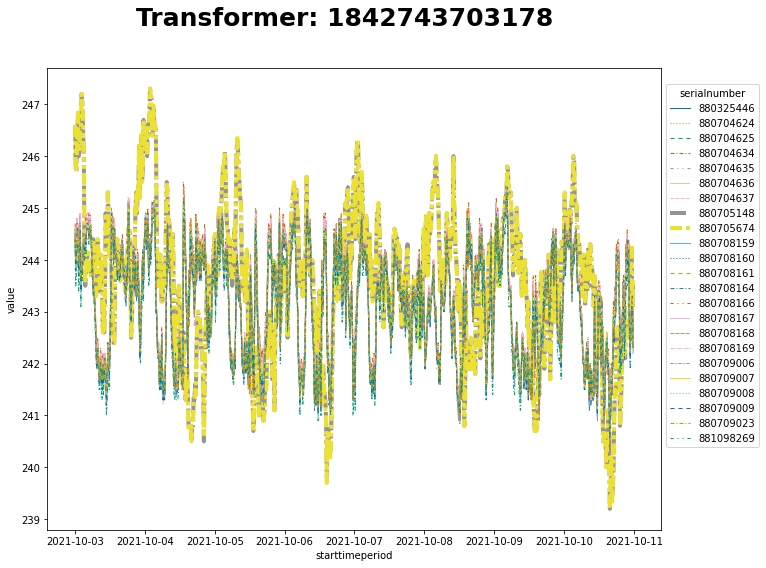

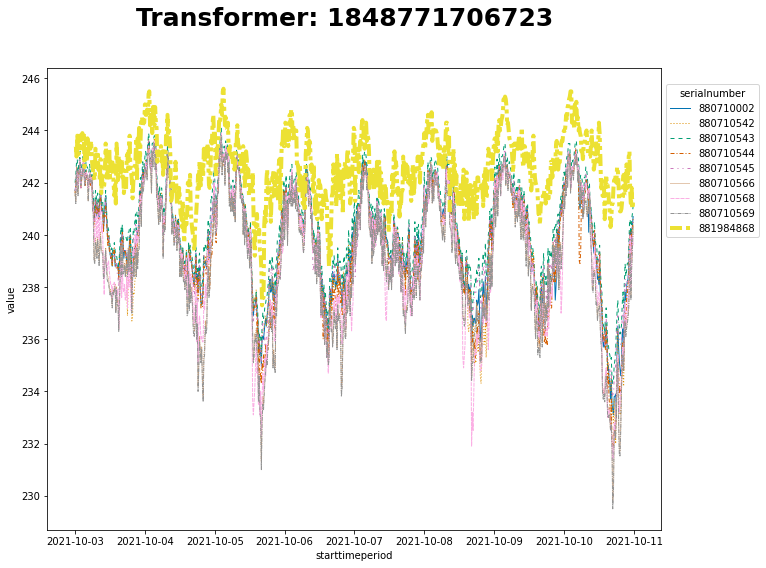

In [13]:
for transformer in transformers:
    tmp_df = df_usage[df_usage['trsf_pole_nb']==transformer].copy()
    tmp_df['serialnumber']=tmp_df['serialnumber'].astype(str)
    if exclude_zeros:
        tmp_df = tmp_df[tmp_df['value']>0]
        
    outliers_df = find_outliers_using_grubbs(tmp_df)
    outlier_ids = outliers_df.index.tolist()
    outliers_linesize = 4
    print(f'Outliers found for transformer {transformer}:')
    print(*outlier_ids, sep='\n')
    
    n_sns = len(tmp_df['serialnumber'].unique())
    linestyles = Plot_General.get_standard_linestyles(n_sns, exclude_loose=True)
    linesizes = [1 for _ in range(n_sns)]
    linesizes = {x:1 for x in tmp_df['serialnumber'].unique().tolist()}
    for outlier_id in outlier_ids:
        linesizes[outlier_id] = outliers_linesize
    
    fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
    sns.lineplot(ax=ax, x='starttimeperiod', y='value', hue='serialnumber', data=tmp_df, 
                 palette='colorblind', 
                 style='serialnumber', dashes=[x[1] for x in linestyles], 
                 size='serialnumber', sizes=linesizes)
    ax.legend(title='serialnumber', bbox_to_anchor=(1, 0.975), loc='upper left')
    fig.suptitle(f'Transformer: {transformer}', fontsize=25, fontweight='bold')
    fig_num +=1

Outliers found for transformer 1842743703178 on date 2021-10-03:
880705148
880705674
Outliers found for transformer 1842743703178 on date 2021-10-04:
880705148
880705674
Outliers found for transformer 1842743703178 on date 2021-10-05:
880705148
880705674
Outliers found for transformer 1842743703178 on date 2021-10-06:
880705148
880705674
Outliers found for transformer 1842743703178 on date 2021-10-07:

Outliers found for transformer 1842743703178 on date 2021-10-08:
880705148
880705674
Outliers found for transformer 1842743703178 on date 2021-10-09:
880705148
880705674
880708164
Outliers found for transformer 1842743703178 on date 2021-10-10:
880705148
880705674
Outliers found for transformer 1848771706723 on date 2021-10-03:
881984868
Outliers found for transformer 1848771706723 on date 2021-10-04:
881984868
Outliers found for transformer 1848771706723 on date 2021-10-05:
881984868
Outliers found for transformer 1848771706723 on date 2021-10-06:
881984868
Outliers found for transforme

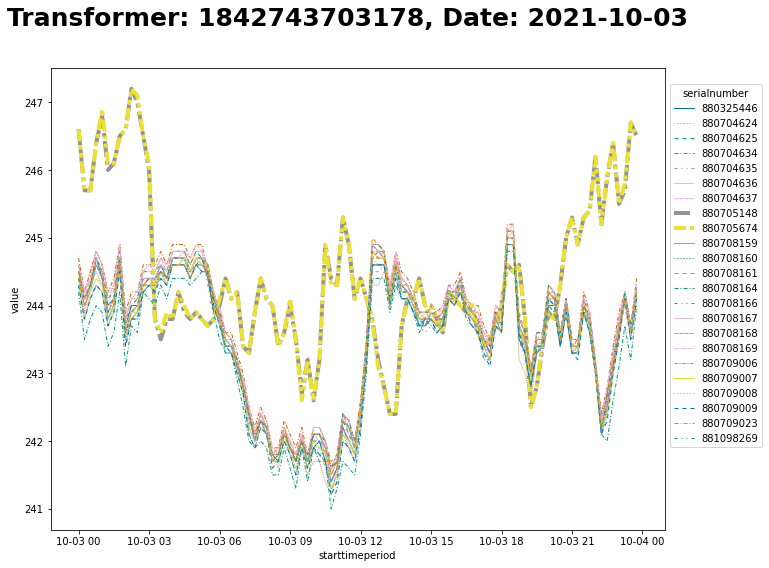

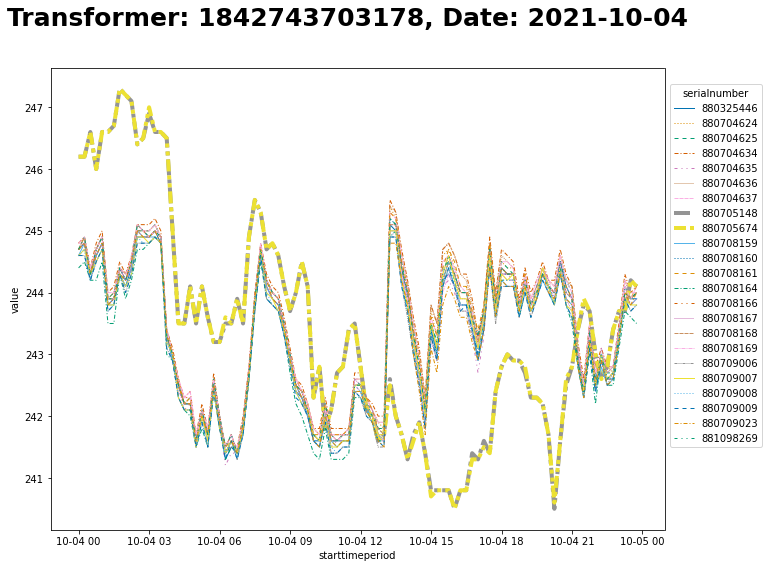

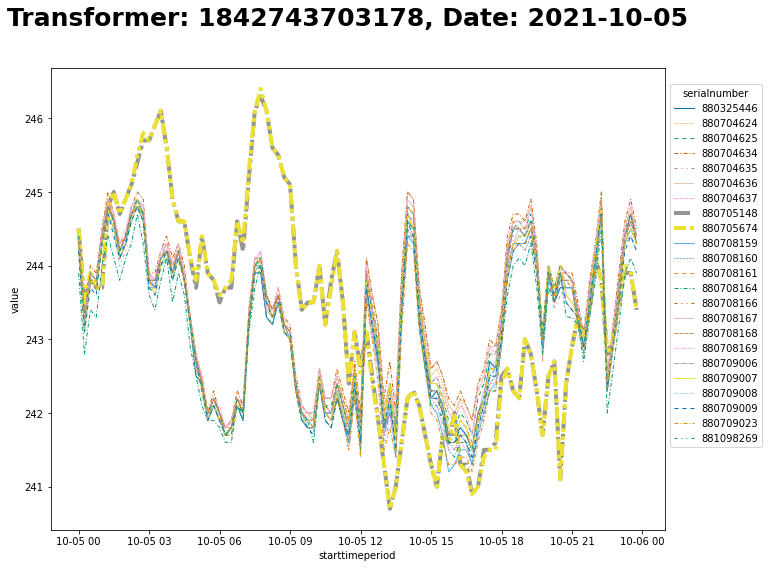

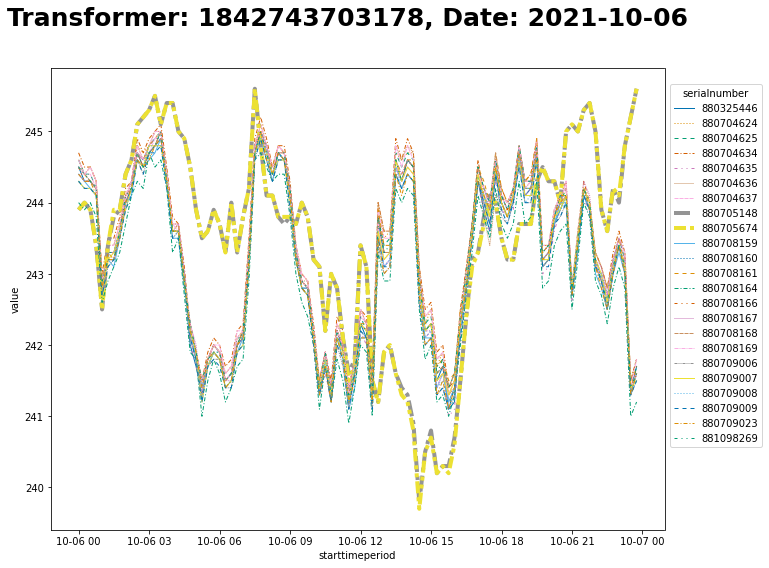

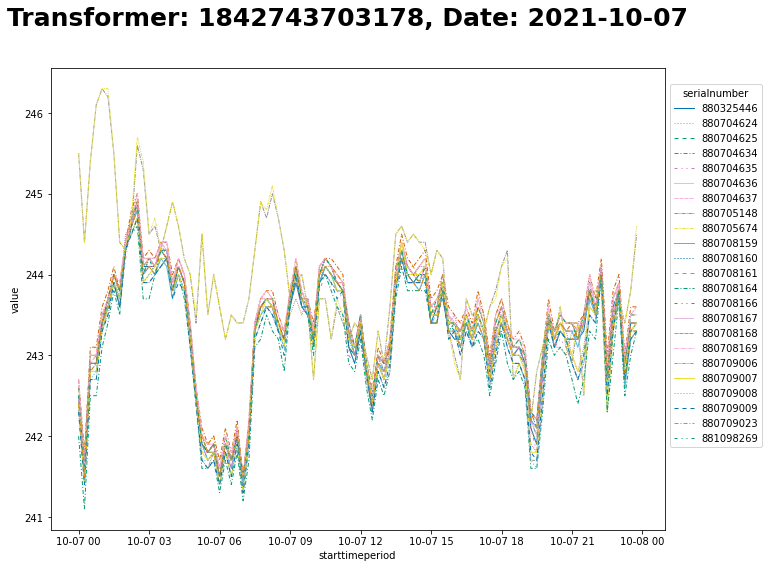

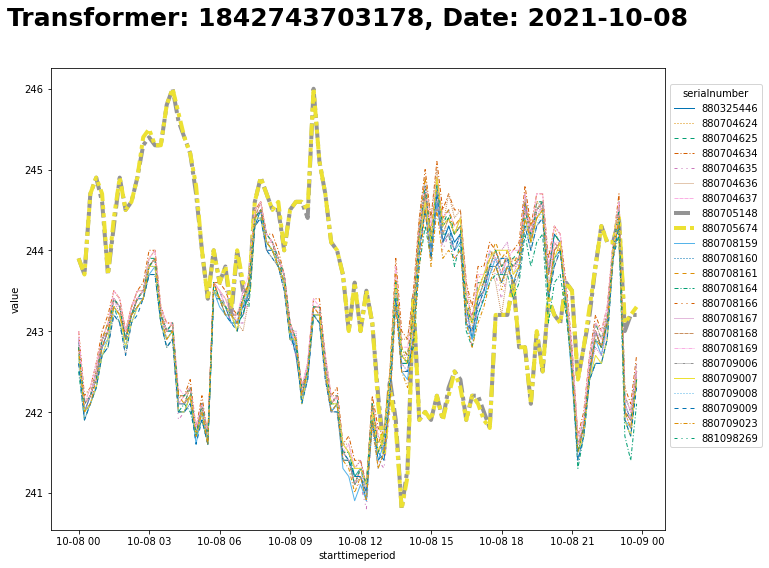

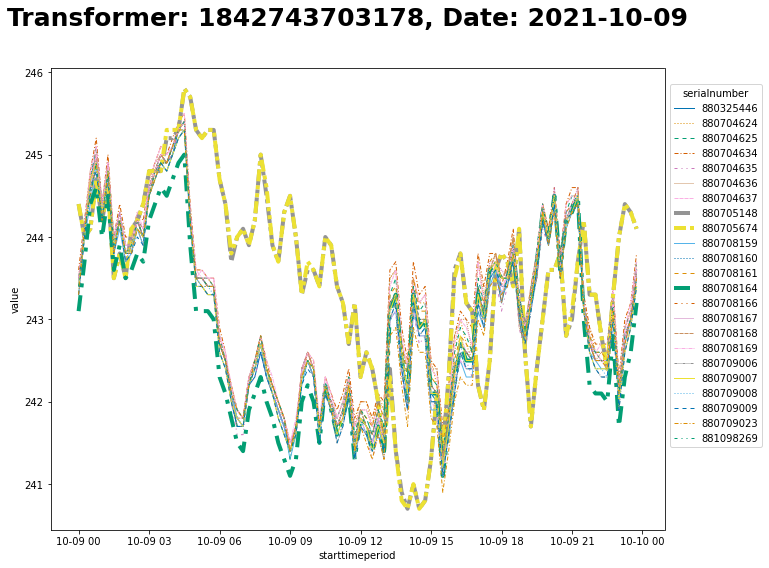

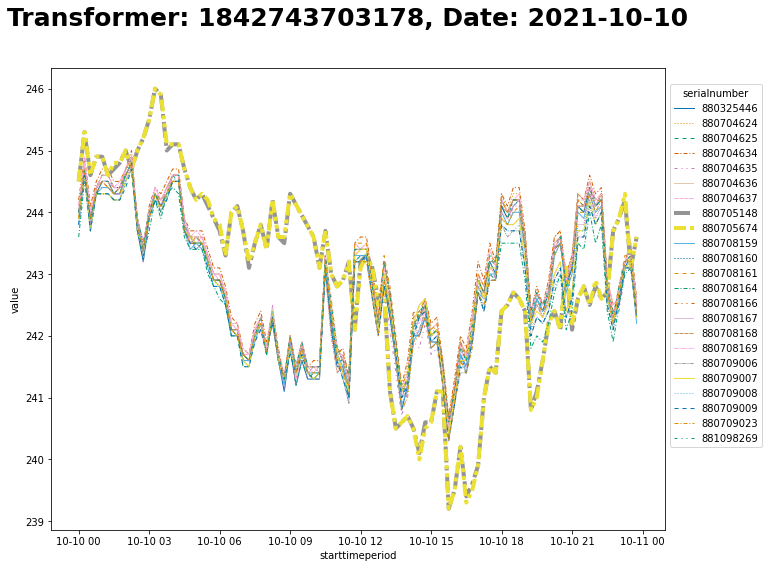

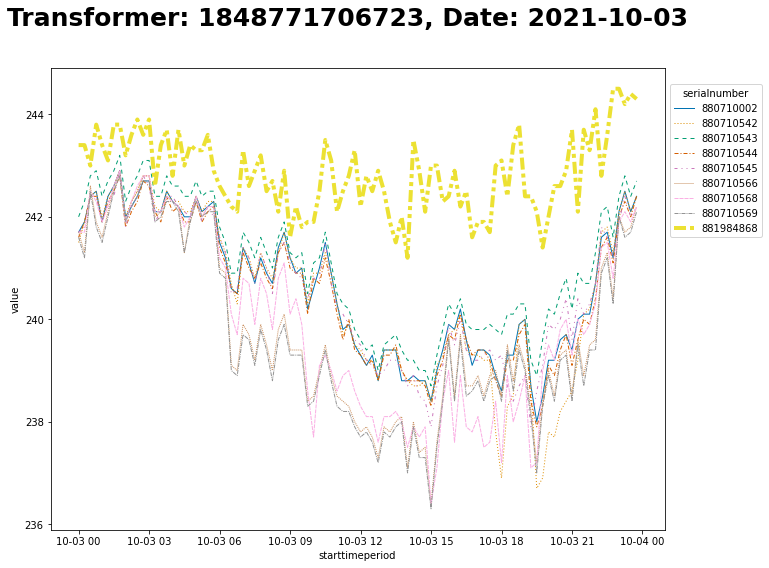

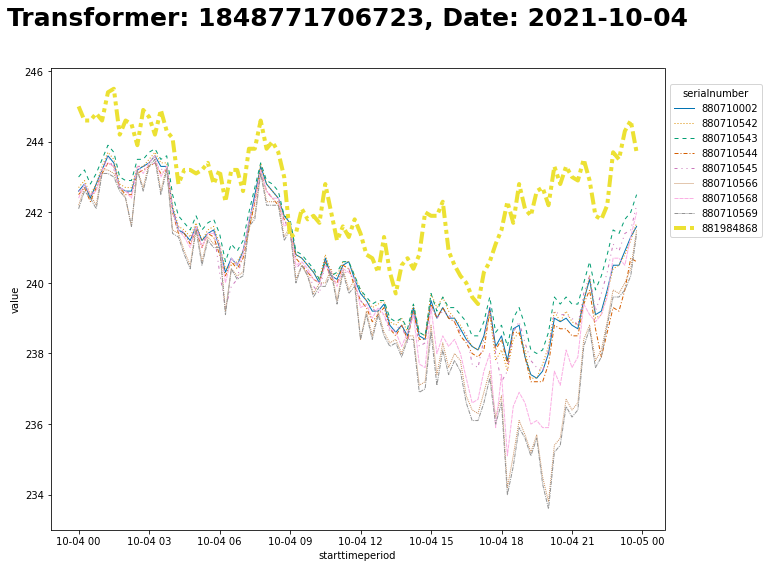

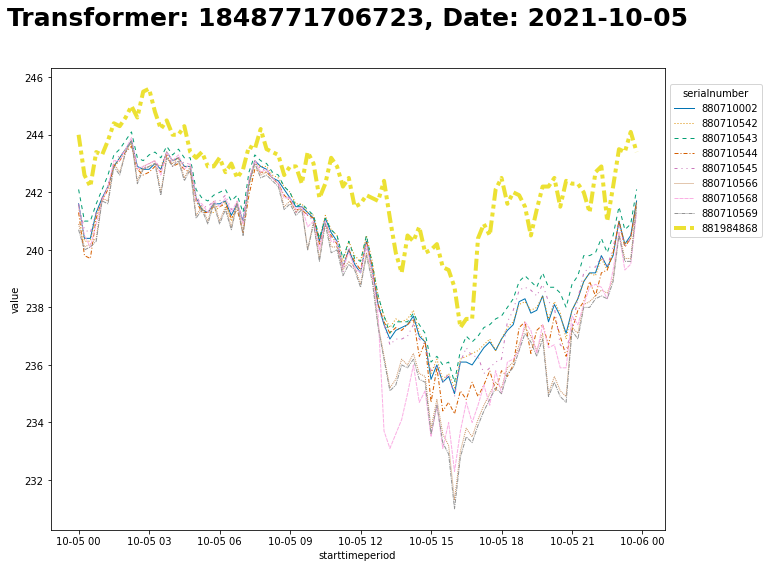

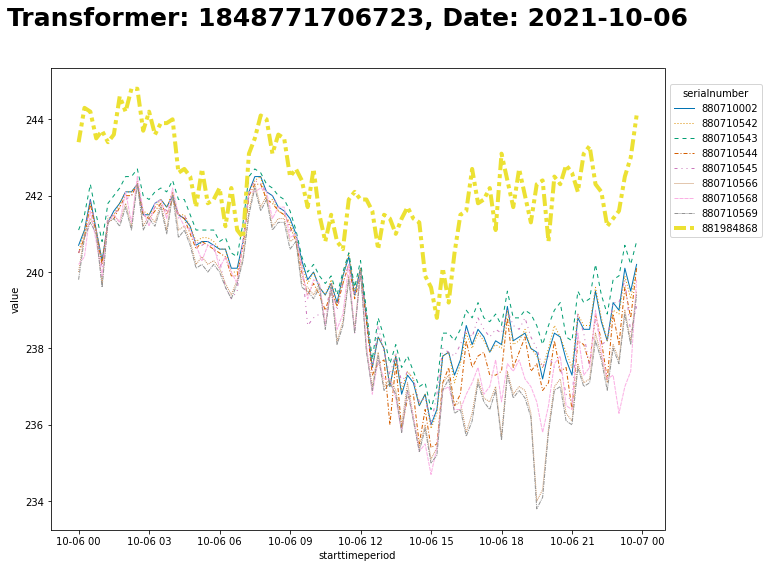

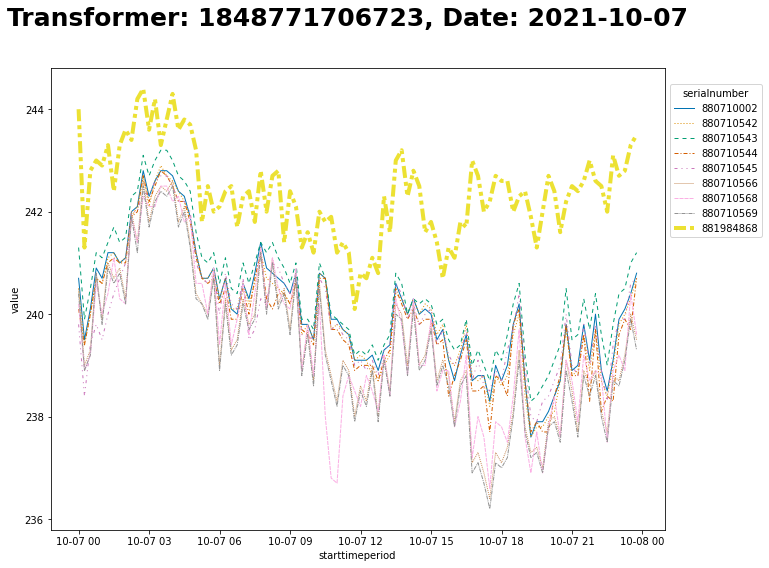

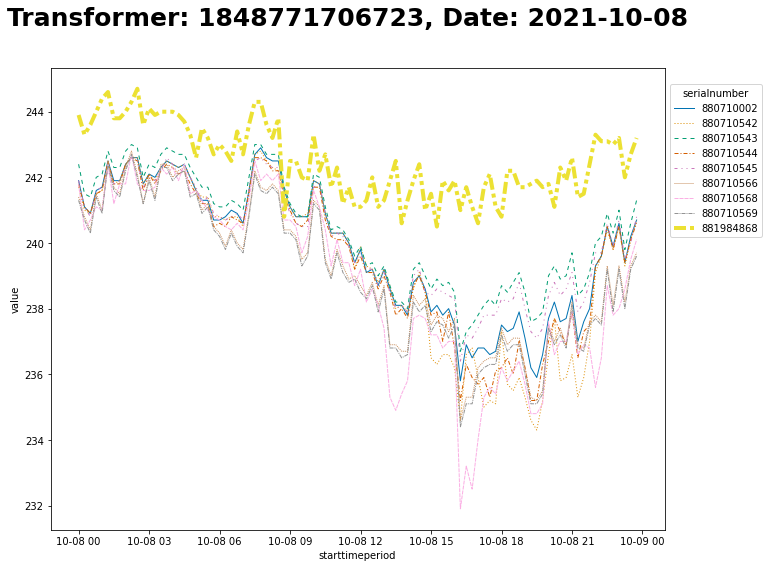

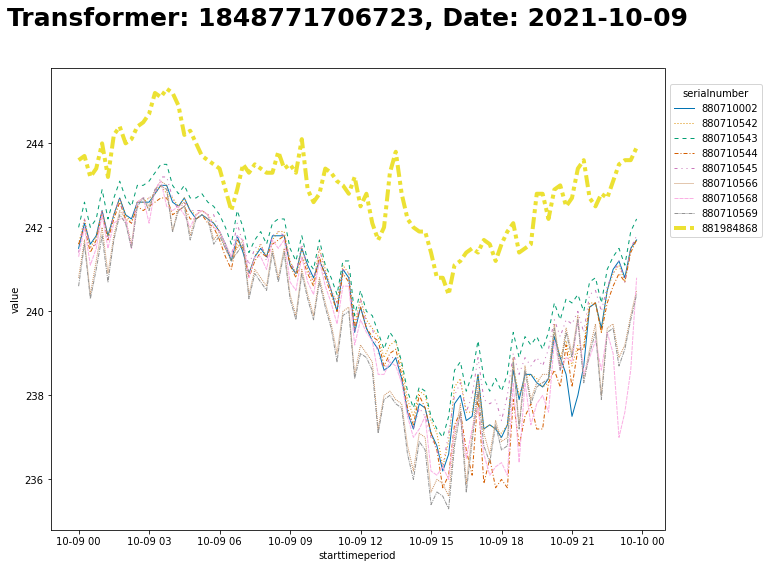

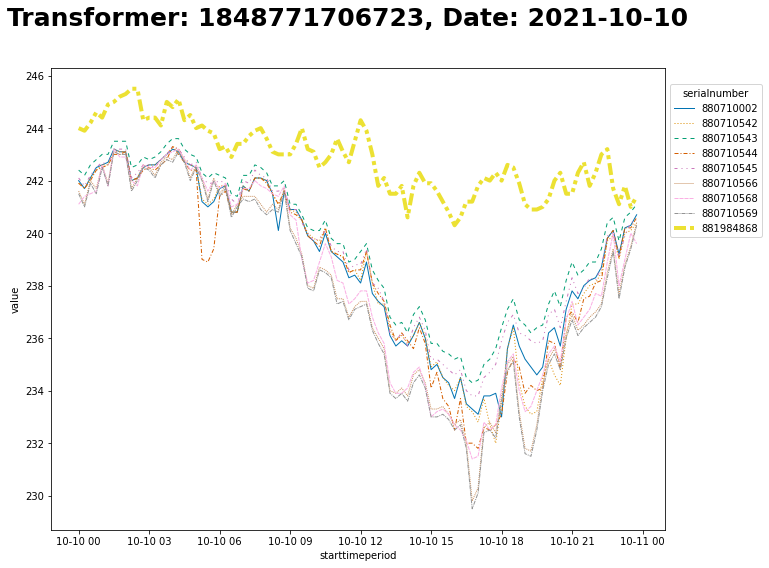

In [14]:
for transformer in transformers:
    for date in dates:    
        tmp_df = df_usage[(df_usage['trsf_pole_nb']==transformer) & (df_usage['aep_usage_dt']==date)].copy()
        tmp_df['serialnumber']=tmp_df['serialnumber'].astype(str)
        if exclude_zeros:
            tmp_df = tmp_df[tmp_df['value']>0]

        outliers_df = find_outliers_using_grubbs(tmp_df)
        outlier_ids = outliers_df.index.tolist()
        outliers_linesize = 4
        print(f'Outliers found for transformer {transformer} on date {date}:')
        print(*outlier_ids, sep='\n')
        
        n_sns = len(tmp_df['serialnumber'].unique())
        linestyles = Plot_General.get_standard_linestyles(n_sns, exclude_loose=True)
        linesizes = [1 for _ in range(n_sns)]
        linesizes = {x:1 for x in tmp_df['serialnumber'].unique().tolist()}
        for outlier_id in outlier_ids:
            linesizes[outlier_id] = outliers_linesize

        fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
        sns.lineplot(ax=ax, x='starttimeperiod', y='value', hue='serialnumber', data=tmp_df, 
                     palette='colorblind', 
                     style='serialnumber', dashes=[x[1] for x in linestyles], 
                     size='serialnumber', sizes=linesizes)
        ax.legend(title='serialnumber', bbox_to_anchor=(1, 0.975), loc='upper left')
        fig.suptitle(f'Transformer: {transformer}, Date: {date}', fontsize=25, fontweight='bold')
        fig_num +=1